In [197]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import numpy as np

In [198]:
def bootstrap_gen(dataframe):
    return dataframe.sample(frac=1,replace=True)
def CVratio(experimentdata):
    return (experimentdata["<y>"].std(ddof=0)/experimentdata["<y>"].mean())/(experimentdata["<x>"].std(ddof=0)/experimentdata["<x>"].mean())
def xycorr(experimentdata):
    return experimentdata["<x>"].corr(experimentdata["<y>"])
def bootstrap_stderr_mean(experimentdata,f,n):
    bootstrap_fs = [f(bootstrap_gen(experimentdata)) for i in range(n)]
    return np.std(bootstrap_fs,ddof=0)/np.sqrt(len(experimentdata)),np.mean(bootstrap_fs)
def joinedbootstrap(experimentdata,n):
    rhos = []
    Cs = []
    for i in range(n):
        sample = bootstrap_gen(experimentdata)
        rhos.append(xycorr(sample))
        Cs.append(CVratio(sample))
    return np.std(Cs)/np.sqrt(len(experimentdata)),np.std(rhos)/np.sqrt(len(experimentdata))


files = glob.glob('no_fb_sims_largerange4_2023-02-02/*_simresults.tsv')
dfs = list()
for f in files:
    data = pd.read_csv(f,sep='\t')
    data['file'] = f
    dfs.append(data)

df = pd.concat(dfs, ignore_index=True)

In [328]:
folders = glob.glob('no_fb_sims_indtest_tausrandommany*')
df = pd.DataFrame()
for i,folder in enumerate(folders):
    files = glob.glob(folder+'/*_simresults.tsv')
    for f in files:
        data = pd.read_csv(f,sep='\t')
        simsettings = pd.read_csv(f[:-14]+'settings.tsv',sep='\t')
        simsettings = simsettings.drop(['cov thres','flux thres'],axis=1)
        data = pd.concat([data,simsettings.loc[simsettings.index.repeat(len(data))].reset_index(drop=True)],axis=1)
        data["file"] = f
        data['covcheck'] = data['cov thres'].apply(lambda x: all(float(i) <= 0.05 for i in x.strip('[]').split(',')))
        df = pd.concat([df,data],ignore_index=True)


In [333]:
cols = ["file","C","rho","std_rho","std_C","covcheck","numsims"]
pertdata = pd.DataFrame(columns=cols)
for f in df['file'].unique():
    #isolate data by parameter set
    experimentdata = df[df["file"] == f]
    #Total sims in the point
    nsims = len(experimentdata)
    #number of sims in data that didn't reach cov balance
    ncov = len(experimentdata[experimentdata["covcheck"]==False])
    #calculate quantity
    rho = xycorr(experimentdata)
    C_val = CVratio(experimentdata)
    #estimate standard error by bootstrapping
    std_Cval,std_rho = joinedbootstrap(experimentdata,5000)
    
    df2 = pd.DataFrame([[f,C_val,rho,std_rho,std_Cval,ncov,nsims]], columns= cols)
    pertdata = pd.concat([pertdata,df2])

All of the points, regardless if good or not

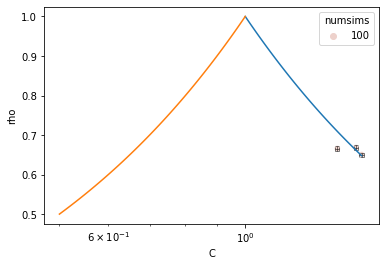

In [334]:
sns.scatterplot(data=pertdata,x="C",y="rho",hue='numsims')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=pertdata, label=None, capsize=2, capthick=0.5,color='k',fmt='none')
plt.plot(np.linspace(1,pertdata["C"].max()),1/np.linspace(1,pertdata["C"].max()))
plt.plot(np.linspace(0.5,1),np.linspace(0.5,1))
plt.xscale('log')

just points where all sims passed covcheck

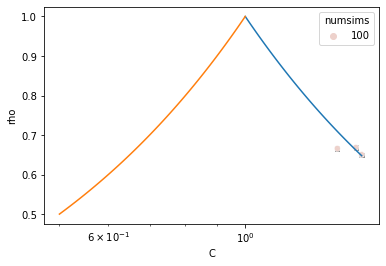

In [335]:
cleared = pertdata[pertdata["covcheck"]==0]
sns.scatterplot(data=cleared,x="C",y="rho",hue='numsims')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=cleared, label=None, capsize=2, capthick=0.5,color='k',fmt='none',zorder=-1)
plt.plot(np.linspace(1,cleared["C"].max()),1/np.linspace(1,cleared["C"].max()))
plt.plot(np.linspace(0.5,1),np.linspace(0.5,1))
plt.xscale('log')

Place to look at other slices

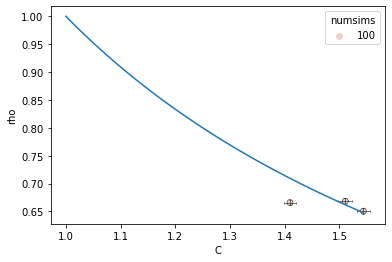

In [336]:
plotted = pertdata[(pertdata['covcheck']==0)]
sns.scatterplot(data=plotted,x="C",y="rho",hue='numsims',alpha=1,edgecolor='k')
plt.errorbar(y="rho", x="C", xerr="std_C", 
              yerr="std_rho", elinewidth=0.5,data=plotted, label=None, capsize=1, capthick=0.5,color='k',fmt='none')
plt.plot(np.linspace(1,plotted["C"].max()),1/np.linspace(1,plotted["C"].max()))

In [337]:
pertdata

,file,C,rho,std_rho,std_C,covcheck,numsims
0,no_fb_sims_indtest_tausrandommany_2023-02-09/p...,1.543748,0.650602,0.005042,0.012337,0,100
0,no_fb_sims_indtest_tausrandommany_2023-02-09/p...,1.409637,0.665956,0.005268,0.01054,0,100
0,no_fb_sims_indtest_tausrandommany_2023-02-09/p...,1.510577,0.668416,0.005173,0.012404,0,100


In [277]:
df.groupby("params")[["<x>","<y>"]].corr()

<x>       <y>
params                                        
[25.0, 1.0, 2.0, 1.0]  <x>  1.000000  0.707162
                       <y>  0.707162  1.000000
[25.0, 13.0, 5.0, 2.0] <x>  1.000000  0.706985
                       <y>  0.706985  1.000000
[40.0, 1.0, 40.0, 1.0] <x>  1.000000  0.707284
                       <y>  0.707284  1.000000

In [278]:
d = df.groupby("params")[["<x>","<y>"]].std()/df.groupby("params")[["<x>","<y>"]].mean()
d["<x>"]/d["<y>"]

params
[25.0, 1.0, 2.0, 1.0]     0.705121
[25.0, 13.0, 5.0, 2.0]    0.707082
[40.0, 1.0, 40.0, 1.0]    0.707075
dtype: float64

params
[25.0, 1.0, 2.0, 1.0]     AxesSubplot(0.125,0.125;0.775x0.755)
[25.0, 13.0, 5.0, 2.0]    AxesSubplot(0.125,0.125;0.775x0.755)
[40.0, 1.0, 40.0, 1.0]    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

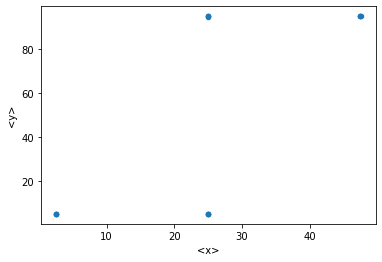

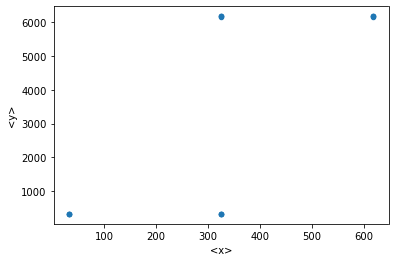

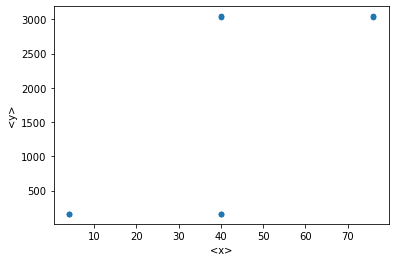

In [279]:
df.groupby("params").plot.scatter("<x>","<y>")

In [252]:
perts = np.array([[2.5,1.,1.,1.],[1.,2.5,1.,1.],[1,1,2.5,1],[1,1,1,2.5],[.00025,1.,1.,1.],[1.,.75,1.,1.],[1,1,.75,1],[1,1,1,.75]])

In [253]:
np.corrcoef(perts,rowvar=False)

array([[ 1.        , -0.02994468, -0.02994468, -0.02994468],
       [-0.02994468,  1.        , -0.09225092, -0.09225092],
       [-0.02994468, -0.09225092,  1.        , -0.09225092],
       [-0.02994468, -0.09225092, -0.09225092,  1.        ]])

In [298]:
a = np.random.uniform(0.8,1.2,(4,1))
b = np.random.uniform(0.8,1.2,(4,1))

In [300]:
H = b @ np.linalg.inv((b.T@b))@b.T

In [312]:
e = (np.eye(4)-H)@a

In [313]:
e

array([[ 0.22411575],
       [-0.04150265],
       [ 0.02952249],
       [-0.17144139]])

In [322]:
np.corrcoef(e,a,rowvar=False)

array([[1.        , 0.90625057],
       [0.90625057, 1.        ]])

In [308]:
a

array([[1.04025823],
       [0.81339825],
       [0.88843848],
       [0.83640782]])

In [342]:
df["usedparams"] = df["usedparams"].apply(lambda x: [i for i in x.strip('[]').split(',')])